使用设备: cuda


c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows11\anaconda3\envs\stylegan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


开始风格迁移...
步骤 [0/800], 内容损失: 0.0000, 风格损失: 49961.7695, 总损失: 49961771008.0000
步骤 [50/800], 内容损失: 6.6967, 风格损失: 2485.7202, 总损失: 2485720320.0000
步骤 [100/800], 内容损失: 6.7238, 风格损失: 1245.2489, 总损失: 1245248896.0000
步骤 [150/800], 内容损失: 6.8540, 风格损失: 926.1952, 总损失: 926195200.0000
步骤 [200/800], 内容损失: 6.9914, 风格损失: 745.6516, 总损失: 745651584.0000
步骤 [250/800], 内容损失: 7.1235, 风格损失: 625.5475, 总损失: 625547520.0000
步骤 [300/800], 内容损失: 7.2456, 风格损失: 542.2784, 总损失: 542278464.0000
步骤 [350/800], 内容损失: 7.3581, 风格损失: 482.8683, 总损失: 482868352.0000
步骤 [400/800], 内容损失: 7.4608, 风格损失: 439.2581, 总损失: 439258048.0000
步骤 [450/800], 内容损失: 7.5554, 风格损失: 406.0367, 总损失: 406036736.0000
步骤 [500/800], 内容损失: 7.6434, 风格损失: 379.6444, 总损失: 379644384.0000
步骤 [550/800], 内容损失: 7.7258, 风格损失: 357.8908, 总损失: 357890784.0000
步骤 [600/800], 内容损失: 7.8031, 风格损失: 339.3833, 总损失: 339383264.0000
步骤 [650/800], 内容损失: 7.8760, 风格损失: 323.2466, 总损失: 323246656.0000
步骤 [700/800], 内容损失: 7.9456, 风格损失: 308.9052, 总损失: 308905216.0000
步骤 [750/800], 内容损失: 8.012

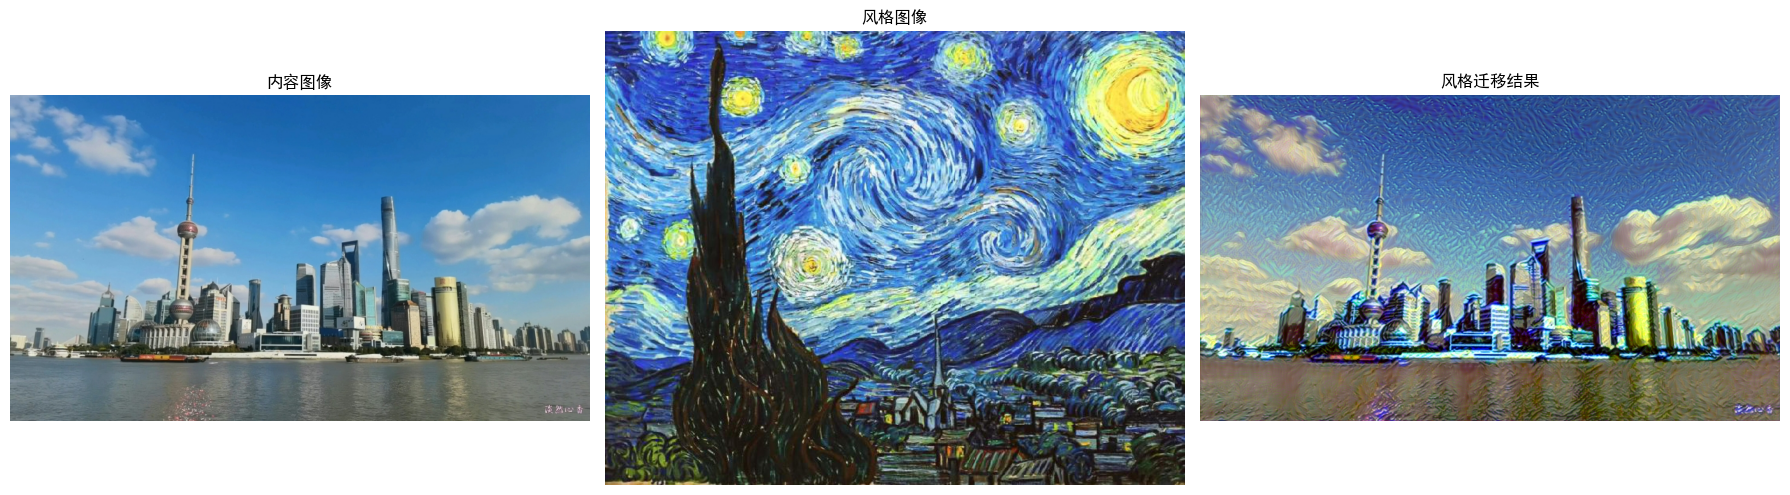

风格迁移结果已保存为 'style_transfer_output.jpg'


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy

class NeuralStyleTransfer:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"使用设备: {device}")
        
        # 加载预训练的VGG19模型
        self.cnn = models.vgg19(pretrained=True).features.to(device).eval()
        
        # 冻结所有参数
        for param in self.cnn.parameters():
            param.requires_grad = False
            
        # 定义用于计算内容和风格损失的层
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        
        # 构建模型，返回中间层输出
        self.model = self.build_model()
        
    def build_model(self):
        """构建返回中间层输出的模型"""
        cnn = copy.deepcopy(self.cnn)
        model = nn.Sequential()
        
        # 跟踪每个卷积层后的批归一化和ReLU
        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)  # 用inplace=False的ReLU
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
                layer = nn.AvgPool2d(kernel_size=2, stride=2)  # 用AvgPool代替MaxPool以获得更平滑的结果
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                raise RuntimeError(f'未识别的层: {layer.__class__.__name__}')
                
            model.add_module(name, layer)
            
        return model
    
    def load_image(self, image_path, shape=None, max_size=512):
        """加载和预处理图像"""
        image = Image.open(image_path).convert('RGB')
        
        # 调整图像大小
        if max(image.size) > max_size:
            size = max_size
        elif shape is not None:
            size = (shape[1], shape[0])
        else:
            size = image.size
            
        in_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), 
                               (0.229, 0.224, 0.225))
        ])
        
        image = in_transform(image).unsqueeze(0)
        return image.to(self.device)
    
    def im_convert(self, tensor):
        """将张量转换回图像格式"""
        image = tensor.to('cpu').clone().detach()
        image = image.numpy().squeeze()
        image = image.transpose(1, 2, 0)
        image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
        image = image.clip(0, 1)
        return image
    
    def get_features(self, image, layers=None):
        """获取指定层的特征"""
        if layers is None:
            layers = {'conv_4': 'content', 
                     'conv_1': 'style', 
                     'conv_2': 'style', 
                     'conv_3': 'style', 
                     'conv_4': 'style',
                     'conv_5': 'style'}
        
        features = {}
        x = image
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in layers:
                features[name] = x
                
        return features
    
    def gram_matrix(self, tensor):
        """计算Gram矩阵（用于风格表示）"""
        _, d, h, w = tensor.size()
        tensor = tensor.view(d, h * w)
        gram = torch.mm(tensor, tensor.t())
        return gram
    
    def transfer_style(self, content_path, style_path, 
                      num_steps=500, 
                      content_weight=1, 
                      style_weight=1e6,
                      learning_rate=0.01):
        """
        执行风格迁移
        
        参数:
        - content_path: 内容图像路径
        - style_path: 风格图像路径
        - num_steps: 迭代次数
        - content_weight: 内容损失的权重
        - style_weight: 风格损失的权重
        - learning_rate: 学习率
        """
        
        # 加载图像
        content = self.load_image(content_path)
        style = self.load_image(style_path, shape=content.shape[-2:])
        
        # 初始化目标图像（从内容图像开始）
        target = content.clone().requires_grad_(True)
        
        # 获取内容特征（只从内容图像）
        content_features = self.get_features(content, layers=self.content_layers)
        
        # 获取风格特征（只从风格图像）
        style_features = self.get_features(style, layers=self.style_layers)
        style_grams = {layer: self.gram_matrix(style_features[layer]) for layer in style_features}
        
        # 优化器（优化目标图像，不是模型参数！）
        optimizer = optim.Adam([target], lr=learning_rate)
        
        print("开始风格迁移...")
        for step in range(num_steps):
            # 前向传播获取目标图像的特征
            target_features = self.get_features(target, layers=set(self.content_layers + self.style_layers))
            
            # 计算内容损失
            content_loss = 0
            for layer in self.content_layers:
                content_loss += torch.mean((target_features[layer] - content_features[layer]) ** 2)
            
            # 计算风格损失
            style_loss = 0
            for layer in self.style_layers:
                target_feature = target_features[layer]
                target_gram = self.gram_matrix(target_feature)
                style_gram = style_grams[layer]
                layer_style_loss = torch.mean((target_gram - style_gram) ** 2)
                style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2] * target_feature.shape[3])
            
            # 总损失
            total_loss = content_weight * content_loss + style_weight * style_loss
            
            # 反向传播
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            if step % 50 == 0:
                print(f"步骤 [{step}/{num_steps}], "
                      f"内容损失: {content_loss.item():.4f}, "
                      f"风格损失: {style_loss.item():.4f}, "
                      f"总损失: {total_loss.item():.4f}")
        
        # 返回最终结果
        final_image = self.im_convert(target)
        return final_image

def visualize_results(content_path, style_path, result_image, save_path=None):
    """可视化内容图像、风格图像和结果"""
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 内容图像
    content_img = Image.open(content_path)
    axes[0].imshow(content_img)
    axes[0].set_title('内容图像')
    axes[0].axis('off')
    
    # 风格图像
    style_img = Image.open(style_path)
    axes[1].imshow(style_img)
    axes[1].set_title('风格图像')
    axes[1].axis('off')
    
    # 结果图像
    axes[2].imshow(result_image)
    axes[2].set_title('风格迁移结果')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# 使用示例
if __name__ == "__main__":
    # 初始化风格迁移器
    nst = NeuralStyleTransfer()
    
    # 图像路径（请替换为你自己的图像路径）
    content_path = "contentImage.jpg"  # 内容图像（如风景、人物）
    style_path = "deepdream_input.jpg"      # 风格图像（如名画）
    
    try:
        # 执行风格迁移
        result = nst.transfer_style(
            content_path=content_path,
            style_path=style_path,
            num_steps=800,        # 迭代次数
            content_weight=1,     # 内容权重
            style_weight=1e6,     # 风格权重
            learning_rate=0.01    # 学习率
        )
        
        # 显示结果
        visualize_results(content_path, style_path, result, "style_transfer_result.jpg")
        
        # 单独保存结果
        plt.imsave("style_transfer_output.jpg", result)
        print("风格迁移结果已保存为 'style_transfer_output.jpg'")
        
    except FileNotFoundError as e:
        print(f"找不到图像文件: {e}")
        print("请确保内容图像和风格图像路径正确")